In [9]:
pip install prophet

In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from prophet import Prophet
from datetime import timedelta, datetime, timezone
import warnings


# --- 1. Cargar y Preprocesar los Datos ---
print("Cargando y preprocesando los datos...")

# Se lee el archivo CSV especificando que el separador es un punto y coma (;)
try:
    df = pd.read_csv('/content/drive/MyDrive/data science/bitcoin.csv', sep=';', decimal=',')
except FileNotFoundError:
    print("Error: Asegúrate de que el archivo 'bitcoin.csv' esté en la misma carpeta que el script.")
    exit()

df.head()

Cargando y preprocesando los datos...


,timeOpen,timeClose,timeHigh,timeLow,priceOpen,priceHigh,priceLow,priceClose,volume
0,1.753100e+12,1.753190e+12,1.753130e+12,1.753100e+12,117306.4670,119671.5641,116584.4004,117439.5358,6.982009e+10
1,1.753010e+12,1.753100e+12,1.753070e+12,1.753090e+12,117944.1092,118865.0341,116550.1361,117300.7857,5.751545e+10
2,1.752930e+12,1.753010e+12,1.752970e+12,1.753000e+12,117998.1274,118541.4017,117388.4107,117939.9787,4.756456e+10
3,1.752840e+12,1.752930e+12,1.752860e+12,1.752910e+12,119284.1118,120851.9178,116925.9812,118003.2245,7.794580e+10
4,1.752750e+12,1.752840e+12,1.752830e+12,1.752800e+12,118738.5060,120999.6072,117508.2160,119289.8422,7.236384e+10


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.tail()

,timeOpen,timeClose,timeHigh,timeLow,priceOpen,priceHigh,priceLow,priceClose,volume
2495,1.535280e+12,1.535370e+12,1.535290e+12,1.535310e+12,6754.64,6774.75,6620.75,6707.26,3.295500e+09
2496,1.535200e+12,1.535280e+12,1.535210e+12,1.535230e+12,6719.95,6789.63,6700.96,6763.19,3.312600e+09
2497,1.535110e+12,1.535200e+12,1.535200e+12,1.535120e+12,6551.52,6719.96,6498.64,6719.96,4.097820e+09
2498,1.535030e+12,1.535110e+12,1.535110e+12,1.535030e+12,6371.34,6546.54,6371.34,6534.88,3.426180e+09
2499,1.534940e+12,1.535030e+12,1.534950e+12,1.535020e+12,6486.25,6816.79,6310.11,6376.71,4.668110e+09


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2503 entries, 0 to 2502
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timeOpen    2503 non-null   float64
 1   timeClose   2503 non-null   float64
 2   timeHigh    2503 non-null   float64
 3   timeLow     2503 non-null   float64
 4   priceOpen   2503 non-null   float64
 5   priceHigh   2503 non-null   float64
 6   priceLow    2503 non-null   float64
 7   priceClose  2503 non-null   float64
 8   volume      2503 non-null   float64
dtypes: float64(9)
memory usage: 176.1 KB


In [13]:
# Convertir Timestamp (UNIX en milisegundos) a datetime.
# Se usa 'timeOpen' como la columna de tiempo y la unidad es 'ms'.
df['datetime'] = pd.to_datetime(df['timeOpen'], unit='ms', utc=True)
df['datetime'] = df['datetime'].dt.tz_localize(None)

# Ordenar los valores por fecha para asegurar la secuencia temporal
df = df.sort_values('datetime')

# Filtrar filas donde 'priceClose' o 'volume' no tengan valor
df = df.dropna(subset=['priceClose', 'volume'])

# Agregar los datos a intervalos diarios para el modelo
df['date'] = df['datetime'].dt.floor('D')
df_daily = df.groupby('date').agg(
    priceClose=('priceClose', 'last'),  # Último precio del día
    volume=('volume', 'sum')   # Suma del volumen diario
).reset_index()

# Renombrar las columnas para que sean compatibles con Prophet ('ds' para fecha, 'y' para valor a predecir)
df_prophet = df_daily.rename(columns={'date': 'ds', 'priceClose': 'y'})

# Añadir la columna de volumen al dataframe de Prophet para usarla después
df_prophet['volume'] = df_daily['volume']

print("Datos preprocesados y listos para el modelo.")

# --- 2. Ajustar el modelo Prophet ---
print("\nAjustando el modelo Prophet...")

Datos preprocesados y listos para el modelo.

Ajustando el modelo Prophet...


In [14]:
#Inicializar el modelo con estacionalidades diaria, semanal y anual Prophet
modelo = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.1   #Flexibilidad para detectar cambios en la tendencia
    )

# Ajustar el modelo a nuestros datos
modelo.fit(df_prophet)

print("Modelo ajustado.")

DEBUG:cmdstanpy:input tempfile: /tmp/tmpeu032h75/u26vigsw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeu032h75/zjtl32bi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84021', 'data', 'file=/tmp/tmpeu032h75/u26vigsw.json', 'init=/tmp/tmpeu032h75/zjtl32bi.json', 'output', 'file=/tmp/tmpeu032h75/prophet_modelusqvf_hp/prophet_model-20250724002740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:27:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:27:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Modelo ajustado.


In [15]:
# --- 3. Realizar la Predicción ---
print("\nRealizando la predicción para los próximos 7 días...")

# Crear un dataframe con las fechas futuras para la predicción
future = modelo.make_future_dataframe(periods=7, freq='D')

# Realizar la predicción
forecast = modelo.predict(future)

# Obtener el precio predicho para el último día (7 días en el futuro)
precio_predicho = forecast['yhat'].iloc[-1]
fecha_prediccion = forecast['ds'].iloc[-1]
print("-" * 40)
print("PREDICCIÓN BASE (PROPHET)")
print(f"Precio predicho para {fecha_prediccion.strftime('%Y-%m-%d')}: ${precio_predicho:,.2f}")
print("-" * 40)


Realizando la predicción para los próximos 7 días...
----------------------------------------
PREDICCIÓN BASE (PROPHET)
Precio predicho para 2025-07-28: $106,017.00
----------------------------------------


In [16]:
# --- 4. Ajuste Bayesiano Simplificado usando el Volumen ---
print("\nAplicando ajuste basado en el volumen reciente...")


Aplicando ajuste basado en el volumen reciente...


In [28]:
# Calcular el volumen promedio de los últimos 7 días históricos
ultimos_7_dias = df_prophet.tail(30)
volumen_promedio = ultimos_7_dias['volume'].mean()
volumen_actual = ultimos_7_dias['volume'].iloc[-1]


In [29]:
# Calcular el cambio relativo en el volumen (evitando división por cero)
if volumen_promedio > 0:
    cambio_volumen = volumen_actual / volumen_promedio
else:
    cambio_volumen = 1.0

# Lógica de ajuste: si el volumen reciente es un 20% mayor que el promedio,
# se aplica un factor de ajuste al alza.
if cambio_volumen > 1.2:
    factor_ajuste = 1.05 # Aumento del 5%
    print(f"INFO: El volumen reciente es {cambio_volumen:.1%} mayor que el promedio. Se aplica un ajuste positivo.")
elif cambio_volumen < 0.8:
    factor_ajuste = 0.95 # Reducción del 5%
    print(f"INFO: El volumen reciente es {cambio_volumen:.1%} menor que el promedio. Se aplica un ajuste negativo.")
else:
    factor_ajuste = 1.0 # Sin ajuste
    print("INFO: El volumen se mantiene estable. No se aplica ajuste.")

INFO: El volumen se mantiene estable. No se aplica ajuste.


In [30]:
# Calcular el precio final ajustado
precio_ajustado = precio_predicho * factor_ajuste
print("-" * 40)
print("PREDICCIÓN FINAL (AJUSTADA POR VOLUMEN)")
print(f"Precio ajustado para {fecha_prediccion.strftime('%Y-%m-%d')}: ${precio_ajustado:,.2f}")
print("-" * 40)

----------------------------------------
PREDICCIÓN FINAL (AJUSTADA POR VOLUMEN)
Precio ajustado para 2025-07-28: $106,017.00
----------------------------------------


In [31]:
# --- 5. Generar Datos para Visualización ---
# Estos datos están listos para ser graficados con Matplotlib o Plotly

# Datos históricos reales
y_historico = df_prophet['y']

# Predicciones del modelo sobre los datos históricos
y_pred_historico = forecast['yhat'].iloc[:-7]

# Predicciones futuras
y_pred_futuro = forecast['yhat'].iloc[-7:]

# Fechas para el eje X
fechas = forecast['ds']
print(f"\nVariables 'y_historico', 'y_pred_historico', 'y_pred_futuro' y 'fechas' están listas para visualización.")


Variables 'y_historico', 'y_pred_historico', 'y_pred_futuro' y 'fechas' están listas para visualización.


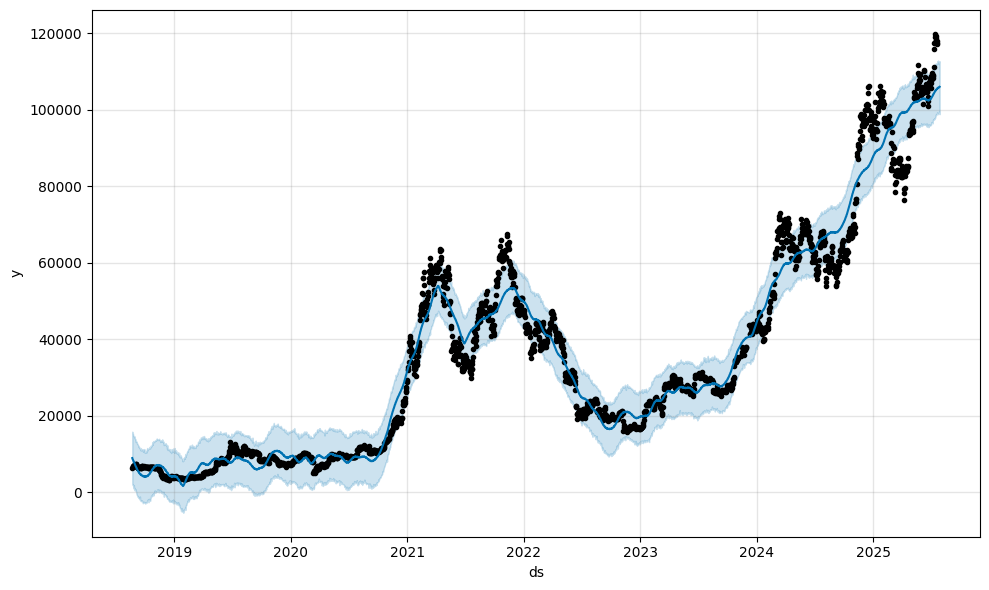

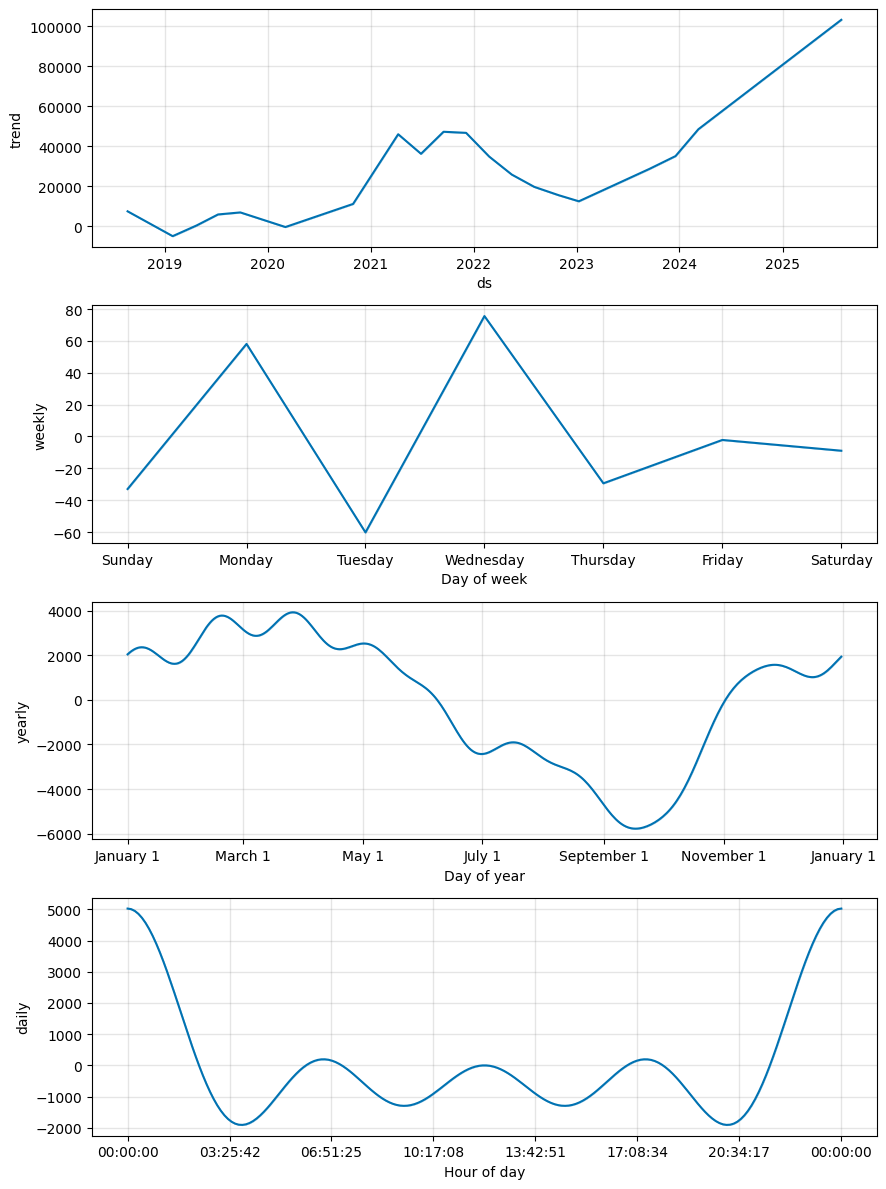

In [32]:
# Ejemplo de cómo podrías visualizar los resultados:
from prophet.plot import plot
fig1 = modelo.plot(forecast)
fig2 = modelo.plot_components(forecast)
plt.show()